In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Load and clean data
df = pd.read_csv("Fbref_2023_2.csv", encoding='latin1')
df.columns = df.columns.str.strip()

In [4]:
# Handle missing values
print(f'Initial Missing Values:\n{df.isnull().sum()}')

Initial Missing Values:
Rk                   0
Edited Name          0
Original Name        0
Matching Name        0
Market Value Euro    7
Nation               0
Pos                  0
Squad                0
Comp                 0
Born                 0
MP                   0
90s                  0
Goals                0
Goals Per Match      0
Shots                0
SoT                  0
G/Sh                 0
G/SoT                0
ShoDist              0
ShoFK                0
ShoPK                0
PKatt                0
PasTotCmp            0
PasTotAtt            0
PasTotDist           0
PasTotPrgDist        0
PasShoCmp            0
PasShoAtt            0
PasMedCmp            0
PasMedAtt            0
PasLonCmp            0
PasLonAtt            0
Assists              0
PasAss               0
Pas3rd               0
PPA                  0
CrsPA                0
PasProg              0
PasLive              0
PasDead              0
PasFK                0
TB                   0
Sw        

In [5]:
# Clean 'Market Value Euro' column
df['Market Value Euro'] = df['Market Value Euro'].str.replace(',', '')
df['Market Value Euro'] = pd.to_numeric(df['Market Value Euro'], errors='coerce').fillna(0).astype(int)

In [6]:
# Replace missing values in 'Market Value Euro' with median for robustness
market_value_median = df[df['Market Value Euro'] > 0]['Market Value Euro'].median()
df['Market Value Euro'] = df['Market Value Euro'].replace(0, market_value_median)

In [7]:
# Verify missing values
print(f'Post-Cleaning Missing Values:\n{df.isnull().sum()}')

Post-Cleaning Missing Values:
Rk                   0
Edited Name          0
Original Name        0
Matching Name        0
Market Value Euro    0
Nation               0
Pos                  0
Squad                0
Comp                 0
Born                 0
MP                   0
90s                  0
Goals                0
Goals Per Match      0
Shots                0
SoT                  0
G/Sh                 0
G/SoT                0
ShoDist              0
ShoFK                0
ShoPK                0
PKatt                0
PasTotCmp            0
PasTotAtt            0
PasTotDist           0
PasTotPrgDist        0
PasShoCmp            0
PasShoAtt            0
PasMedCmp            0
PasMedAtt            0
PasLonCmp            0
PasLonAtt            0
Assists              0
PasAss               0
Pas3rd               0
PPA                  0
CrsPA                0
PasProg              0
PasLive              0
PasDead              0
PasFK                0
TB                   0
Sw  

In [8]:
df.head()

,Rk,Edited Name,Original Name,Matching Name,Market Value Euro,Nation,Pos,Squad,Comp,Born,MP,90s,Goals,Goals Per Match,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost
0,1,Brenden Aaronson,Brenden Aaronson,Brenden Aaronson,25000000,USA,MF,Leeds United,Premier League,2000,20,17.7,1,0.05,1.53,0.28,0.04,0.20,19.0,0.11,0.0,0.0,23.2,31.0,293.0,85.7,13.3,16.2,5.93,7.74,0.90,2.37,0.11,1.75,1.75,0.45,0.11,3.22,28.1,2.88,0.96,0.17,0.00,2.54,0.23,1.47,0.68,0.62,0.06,23.2,0.00,0.85,3.62,2.37,0.56,0.23,0.11,0.28,0.06,0.28,0.17,0.0,0.0,0.06,0.0,0.06,1.64,0.51,0.45,0.90,0.28,0.51,1.47,0.96,1.69,0.11,1.58,0.06,0.28,0.06,44.0,0.40,4.35,19.0,21.50,2.49,44.0,3.73,1.19,1.75,26.7,136.1,56.6,1.53,1.07,0.40,2.60,3.11,30.2,5.65,0.11,0.0,0.0,0.62,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19
1,2,Yunis Abdelhamid,Yunis Abdelhamid,Yunis Abdelhamid,700000,MAR,DF,Reims,Ligue 1,1987,22,22.0,0,-,0.86,0.05,0.00,0.00,13.5,0.00,0.0,0.0,38.5,47.2,751.5,318.5,10.9,12.9,23.20,25.70,3.77,7.00,0.05,0.27,2.91,0.09,0.00,4.50,43.3,3.73,3.32,0.00,0.55,0.18,0.09,0.00,0.00,0.00,0.00,38.5,0.23,0.59,1.14,0.86,0.00,0.00,0.18,0.00,0.09,0.18,0.14,0.0,0.0,0.05,0.0,0.00,2.50,1.59,1.45,1.00,0.05,1.32,1.68,0.36,2.23,0.77,1.45,2.00,2.91,0.05,59.2,6.23,27.50,29.5,2.73,1.09,59.2,0.68,0.32,0.36,40.0,234.2,125.0,0.55,0.23,0.09,0.73,0.68,34.5,0.23,0.09,0.0,0.0,1.32,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23
2,3,Himad Abdelli,Himad Abdelli,Himad Abdelli,2500000,FRA,MF,Angers,Ligue 1,1999,14,8.6,0,-,1.05,0.35,0.00,0.00,19.2,0.00,0.0,0.0,40.0,49.5,676.0,188.1,18.5,22.0,15.50,18.70,4.42,5.93,0.00,1.51,3.95,1.74,0.35,6.40,48.1,1.16,0.35,0.12,0.23,1.05,0.81,0.00,0.00,0.00,0.00,40.0,0.23,1.16,2.67,2.44,0.00,0.00,0.12,0.00,0.12,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.91,1.40,1.28,1.40,0.23,1.63,2.67,1.05,1.51,0.12,1.40,0.93,0.93,0.00,62.6,0.93,11.40,36.0,17.40,1.16,62.6,3.84,2.09,1.51,48.5,298.5,151.0,2.56,2.56,0.47,2.09,1.05,43.4,5.93,0.12,0.0,0.0,1.74,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05
3,4,Salis Abdul Samed,Salis Abdul Samed,Salis Abdul Samed,13000000,GHA,MF,Lens,Ligue 1,2000,20,20.0,1,0.05,0.60,0.15,0.08,0.33,20.3,0.00,0.0,0.0,59.5,64.9,946.3,226.9,29.6,31.8,24.70,26.20,3.35,4.30,0.00,0.50,6.00,0.55,0.10,5.60,63.1,1.40,1.30,0.05,0.20,0.35,0.10,0.00,0.00,0.00,0.00,59.5,0.35,0.40,1.60,1.35,0.00,0.10,0.10,0.00,0.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,1.50,0.80,0.55,0.85,0.10,0.85,1.30,0.45,1.30,0.35,0.95,1.10,0.80,0.00,73.3,2.10,12.00,49.6,12.20,0.70,73.3,1.25,0.70,0.40,61.0,316.9,117.5,1.25,1.95,0.15,1.35,1.30,56.5,1.70,0.15,0.0,0.0,2.45,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50
4,5,Laurent Abergel,Laurent Abergel,Laurent Abergel,3000000,FRA,MF,Lorient,Ligue 1,1993,15,12.9,0,-,0.31,0.00,0.00,0.00,23.9,0.00,0.0,0.0,37.9,43.4,613.6,224.7,17.9,19.4,15.70,17.80,2.64,3.95,0.08,0.62,3.88,0.39,0.00,5.04,42.6,0.78,0.78,0.39,0.16,0.23,0.00,0.00,0.00,0.00,0.00,37.9,0.08,0.31,1.24,1.01,0.08,0.00,0.08,0.00,0.08,0.08,0.08,0.0,0.0,0.00,0.0,0.00,3.80,2.02,2.64,1.16,0.00,1.32,3.26,1.94,1.40,0.23,1.16,1.16,1.55,0.00,54.7,3.26,19.20,31.4,4.88,0.23,54.7,0.93,0.54,0.31,41.0,174.3,72.7,0.47,0.93,0.00,1.32,0.78,36.4,0.47,0.16,0.0,0.0,0.93,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39


In [9]:
df.describe()

,Rk,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost
count,2442.000000,2.442000e+03,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000
mean,1324.375102,1.118568e+07,1996.330467,11.869369,8.264087,1.104423,1.330631,0.443612,0.068911,0.179005,15.185053,0.038800,0.008403,0.011462,33.976331,43.307928,571.371335,179.448014,16.096941,18.64459,13.756241,16.506405,2.960885,5.242219,0.088530,0.930528,2.658812,0.796441,0.214046,3.563423,39.518857,3.612158,0.901552,0.117318,0.331241,1.778943,1.966839,0.445012,0.188984,0.170749,0.003391,33.976331,0.176585,0.972899,2.198485,1.586884,0.178567,0.119521,0.160479,0.11464,0.038436,0.222416,0.152027,0.011052,0.015049,0.027707,0.013673,0.002912,1.816425,1.05645,0.867617,0.693640,0.255213,0.797666,1.533747,0.736003,1.152228,0.292789,0.859562,0.871716,1.643837,0.019521,54.790377,2.917985,14.342695,25.826912,15.218153,2.314869,54.778747,1.918600,0.765340,0.910852,32.288202,174.633018,83.667793,1.786650,1.355287,0.466048,1.774869,1.114959,35.528288,4.227203,0.254083,0.017776,0.007322,1.385459,1.203628,0.220315,1.778943,1.05645,0.010008,0.015262,0.003108,5.189902,1.374541,1.593821
std,778.250236,1.633751e+07,4.351341,6.768282,6.364620,2.074244,1.428985,0.779610,0.122111,0.267803,8.092930,0.207546,0.040666,0.051811,17.410455,18.886052,330.940994,121.803843,8.303252,8.70362,9.385421,9.891819,2.642681,3.859972,0.282853,1.095796,2.188480,1.092908,0.539694,2.517976,17.751095,3.787436,1.095920,0.398575,0.586980,2.362002,3.405369,1.117561,0.669826,0.525090,0.030025,17.410455,0.416665,1.088265,1.895857,1.428765,0.499852,0.464115,0.477930,0.27421,0.164184,0.475926,0.351678,0.055001,0.142740,0.260786,0.057264,0.024733,1.737980,1.25410,1.181219,0.929353,0.589007,1.018922,1.524399,0.981666,1.195067,0.495496,1.114037,0.878527,1.740125,0.065221,19.295595,3.163739,11.142585,12.474453,10.248563,2.515421,19.300294,2.264234,1.199748,1.280282,14.148413,96.267585,57.622085,1.942555,1.543943,0.890674,1.859116,1.535594,15.111736,4.126963,0.599642,0.235879,0.114240,1.431151,1.235570,0.573939,2.362002,1.25410,0.045635,0.078134,0.021258,2.812007,1.570325,1.860780

In [10]:
# Encode with LabelEncoder
le = LabelEncoder()
df['Pos_Cat'] = le.fit_transform(df['Pos'])
df['Nation_Cat'] = le.fit_transform(df['Nation'])
df['Squad_Cat'] = le.fit_transform(df['Squad'])
df['Comp_Cat'] = le.fit_transform(df['Comp'])

In [11]:
df.head()

,Rk,Edited Name,Original Name,Matching Name,Market Value Euro,Nation,Pos,Squad,Comp,Born,MP,90s,Goals,Goals Per Match,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
0,1,Brenden Aaronson,Brenden Aaronson,Brenden Aaronson,25000000,USA,MF,Leeds United,Premier League,2000,20,17.7,1,0.05,1.53,0.28,0.04,0.20,19.0,0.11,0.0,0.0,23.2,31.0,293.0,85.7,13.3,16.2,5.93,7.74,0.90,2.37,0.11,1.75,1.75,0.45,0.11,3.22,28.1,2.88,0.96,0.17,0.00,2.54,0.23,1.47,0.68,0.62,0.06,23.2,0.00,0.85,3.62,2.37,0.56,0.23,0.11,0.28,0.06,0.28,0.17,0.0,0.0,0.06,0.0,0.06,1.64,0.51,0.45,0.90,0.28,0.51,1.47,0.96,1.69,0.11,1.58,0.06,0.28,0.06,44.0,0.40,4.35,19.0,21.50,2.49,44.0,3.73,1.19,1.75,26.7,136.1,56.6,1.53,1.07,0.40,2.60,3.11,30.2,5.65,0.11,0.0,0.0,0.62,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19,2,98,44,3
1,2,Yunis Abdelhamid,Yunis Abdelhamid,Yunis Abdelhamid,700000,MAR,DF,Reims,Ligue 1,1987,22,22.0,0,-,0.86,0.05,0.00,0.00,13.5,0.00,0.0,0.0,38.5,47.2,751.5,318.5,10.9,12.9,23.20,25.70,3.77,7.00,0.05,0.27,2.91,0.09,0.00,4.50,43.3,3.73,3.32,0.00,0.55,0.18,0.09,0.00,0.00,0.00,0.00,38.5,0.23,0.59,1.14,0.86,0.00,0.00,0.18,0.00,0.09,0.18,0.14,0.0,0.0,0.05,0.0,0.00,2.50,1.59,1.45,1.00,0.05,1.32,1.68,0.36,2.23,0.77,1.45,2.00,2.91,0.05,59.2,6.23,27.50,29.5,2.73,1.09,59.2,0.68,0.32,0.36,40.0,234.2,125.0,0.55,0.23,0.09,0.73,0.68,34.5,0.23,0.09,0.0,0.0,1.32,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23,0,64,73,2
2,3,Himad Abdelli,Himad Abdelli,Himad Abdelli,2500000,FRA,MF,Angers,Ligue 1,1999,14,8.6,0,-,1.05,0.35,0.00,0.00,19.2,0.00,0.0,0.0,40.0,49.5,676.0,188.1,18.5,22.0,15.50,18.70,4.42,5.93,0.00,1.51,3.95,1.74,0.35,6.40,48.1,1.16,0.35,0.12,0.23,1.05,0.81,0.00,0.00,0.00,0.00,40.0,0.23,1.16,2.67,2.44,0.00,0.00,0.12,0.00,0.12,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.91,1.40,1.28,1.40,0.23,1.63,2.67,1.05,1.51,0.12,1.40,0.93,0.93,0.00,62.6,0.93,11.40,36.0,17.40,1.16,62.6,3.84,2.09,1.51,48.5,298.5,151.0,2.56,2.56,0.47,2.09,1.05,43.4,5.93,0.12,0.0,0.0,1.74,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05,2,36,2,2
3,4,Salis Abdul Samed,Salis Abdul Samed,Salis Abdul Samed,13000000,GHA,MF,Lens,Ligue 1,2000,20,20.0,1,0.05,0.60,0.15,0.08,0.33,20.3,0.00,0.0,0.0,59.5,64.9,946.3,226.9,29.6,31.8,24.70,26.20,3.35,4.30,0.00,0.50,6.00,0.55,0.10,5.60,63.1,1.40,1.30,0.05,0.20,0.35,0.10,0.00,0.00,0.00,0.00,59.5,0.35,0.40,1.60,1.35,0.00,0.10,0.10,0.00,0.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,1.50,0.80,0.55,0.85,0.10,0.85,1.30,0.45,1.30,0.35,0.95,1.10,0.80,0.00,73.3,2.10,12.00,49.6,12.20,0.70,73.3,1.25,0.70,0.40,61.0,316.9,117.5,1.25,1.95,0.15,1.35,1.30,56.5,1.70,0.15,0.0,0.0,2.45,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50,2,41,46,2
4,5,Laurent Abergel,Laurent Abergel,Laurent Abergel,3000000,FRA,MF,Lorient,Ligue 1,1993,15,12.9,0,-,0.31,0.00,0.00,0.00,23.9,0.00,0.0,0.0,37.9,43.4,613.6,224.7,17.9,19.4,15.70,17.80,2.64,3.95,0.08,0.62,3.88,0.39,0.00,5.04,42.6,0.78,0.78,0.39,0.16,0.23,0.00,0.00,0.00,0.00,0.00,37.9,0.08,0.31,1.24,1.01,0.08,0.00,0.08,0.00,0.08,0.08,0.08,0.0,0.0,0.00,0.0,0.00,3.80,2.02,2.64,1.16,0.00,1.32,3.26,1.94,1.40,0.23,1.16,1.16,1.55,0.00,54.7,3.26,19.20,31.4,4.88,0.23,54.7,0.93,0.54,0.31,41.0,174.3,72.7,0.47,0.93,0.00,1.32,0.78,36.4,0.47,0.16,0.0,0.0,0.93,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39,2,36,50,2


In [12]:
# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

In [13]:
numeric_df.head()

,Rk,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
0,1,25000000,2000,20,17.7,1,1.53,0.28,0.04,0.20,19.0,0.11,0.0,0.0,23.2,31.0,293.0,85.7,13.3,16.2,5.93,7.74,0.90,2.37,0.11,1.75,1.75,0.45,0.11,3.22,28.1,2.88,0.96,0.17,0.00,2.54,0.23,1.47,0.68,0.62,0.06,23.2,0.00,0.85,3.62,2.37,0.56,0.23,0.11,0.28,0.06,0.28,0.17,0.0,0.0,0.06,0.0,0.06,1.64,0.51,0.45,0.90,0.28,0.51,1.47,0.96,1.69,0.11,1.58,0.06,0.28,0.06,44.0,0.40,4.35,19.0,21.50,2.49,44.0,3.73,1.19,1.75,26.7,136.1,56.6,1.53,1.07,0.40,2.60,3.11,30.2,5.65,0.11,0.0,0.0,0.62,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19,2,98,44,3
1,2,700000,1987,22,22.0,0,0.86,0.05,0.00,0.00,13.5,0.00,0.0,0.0,38.5,47.2,751.5,318.5,10.9,12.9,23.20,25.70,3.77,7.00,0.05,0.27,2.91,0.09,0.00,4.50,43.3,3.73,3.32,0.00,0.55,0.18,0.09,0.00,0.00,0.00,0.00,38.5,0.23,0.59,1.14,0.86,0.00,0.00,0.18,0.00,0.09,0.18,0.14,0.0,0.0,0.05,0.0,0.00,2.50,1.59,1.45,1.00,0.05,1.32,1.68,0.36,2.23,0.77,1.45,2.00,2.91,0.05,59.2,6.23,27.50,29.5,2.73,1.09,59.2,0.68,0.32,0.36,40.0,234.2,125.0,0.55,0.23,0.09,0.73,0.68,34.5,0.23,0.09,0.0,0.0,1.32,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23,0,64,73,2
2,3,2500000,1999,14,8.6,0,1.05,0.35,0.00,0.00,19.2,0.00,0.0,0.0,40.0,49.5,676.0,188.1,18.5,22.0,15.50,18.70,4.42,5.93,0.00,1.51,3.95,1.74,0.35,6.40,48.1,1.16,0.35,0.12,0.23,1.05,0.81,0.00,0.00,0.00,0.00,40.0,0.23,1.16,2.67,2.44,0.00,0.00,0.12,0.00,0.12,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.91,1.40,1.28,1.40,0.23,1.63,2.67,1.05,1.51,0.12,1.40,0.93,0.93,0.00,62.6,0.93,11.40,36.0,17.40,1.16,62.6,3.84,2.09,1.51,48.5,298.5,151.0,2.56,2.56,0.47,2.09,1.05,43.4,5.93,0.12,0.0,0.0,1.74,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05,2,36,2,2
3,4,13000000,2000,20,20.0,1,0.60,0.15,0.08,0.33,20.3,0.00,0.0,0.0,59.5,64.9,946.3,226.9,29.6,31.8,24.70,26.20,3.35,4.30,0.00,0.50,6.00,0.55,0.10,5.60,63.1,1.40,1.30,0.05,0.20,0.35,0.10,0.00,0.00,0.00,0.00,59.5,0.35,0.40,1.60,1.35,0.00,0.10,0.10,0.00,0.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,1.50,0.80,0.55,0.85,0.10,0.85,1.30,0.45,1.30,0.35,0.95,1.10,0.80,0.00,73.3,2.10,12.00,49.6,12.20,0.70,73.3,1.25,0.70,0.40,61.0,316.9,117.5,1.25,1.95,0.15,1.35,1.30,56.5,1.70,0.15,0.0,0.0,2.45,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50,2,41,46,2
4,5,3000000,1993,15,12.9,0,0.31,0.00,0.00,0.00,23.9,0.00,0.0,0.0,37.9,43.4,613.6,224.7,17.9,19.4,15.70,17.80,2.64,3.95,0.08,0.62,3.88,0.39,0.00,5.04,42.6,0.78,0.78,0.39,0.16,0.23,0.00,0.00,0.00,0.00,0.00,37.9,0.08,0.31,1.24,1.01,0.08,0.00,0.08,0.00,0.08,0.08,0.08,0.0,0.0,0.00,0.0,0.00,3.80,2.02,2.64,1.16,0.00,1.32,3.26,1.94,1.40,0.23,1.16,1.16,1.55,0.00,54.7,3.26,19.20,31.4,4.88,0.23,54.7,0.93,0.54,0.31,41.0,174.3,72.7,0.47,0.93,0.00,1.32,0.78,36.4,0.47,0.16,0.0,0.0,0.93,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39,2,36,50,2


In [14]:
# Scale features using RobustScaler
scaler = RobustScaler()
features_to_scale = numeric_df.drop(columns=['Pos_Cat','Nation_Cat','Squad_Cat','Comp_Cat'])
scaled_features = scaler.fit_transform(features_to_scale)
scaled_numeric_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

In [15]:
# Shift the scaled data to ensure no negative values
min_value = scaled_features.min()
shifted_scaled_features = scaled_features - min_value

In [16]:
# Convert back to DataFrame
scaled_numeric_df = pd.DataFrame(shifted_scaled_features, columns=features_to_scale.columns)

In [17]:
# Add non-scaled columns
# scaled_numeric_df['Market Value Euro'] = df['Market Value Euro']
scaled_numeric_df['Pos_Cat'] = df['Pos_Cat']
scaled_numeric_df['Nation_Cat'] = df['Nation_Cat']
scaled_numeric_df['Squad_Cat'] = df['Squad_Cat']
scaled_numeric_df['Comp_Cat'] = df['Comp_Cat']

In [18]:
# Drop 'Rk' if exists in the dataset
if 'Rk' in scaled_numeric_df.columns:
    scaled_numeric_df = scaled_numeric_df.drop('Rk', axis=1)

In [19]:
scaled_numeric_df.head()

,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
0,4.061404,2.823308,2.933198,3.297392,3.394737,2.755496,2.472862,2.758373,3.000797,2.720580,2.504737,2.394737,2.394737,1.960646,1.902557,1.826385,1.935824,2.209170,2.234737,1.855241,1.749808,1.894737,1.934661,3.311404,3.295638,2.159320,2.262084,2.787594,2.353692,1.903090,2.573721,2.653478,3.702429,2.054311,3.052658,2.369259,10.131579,3.074737,3.014737,2.454737,1.960646,2.019737,2.416242,3.180114,3.012623,6.702429,4.485646,2.973684,4.293042,2.454737,2.957237,2.894737,2.394737,2.394737,2.454737,2.394737,2.454737,2.429702,1.995815,2.142105,2.896479,2.818979,2.228070,2.503264,2.942682,3.232237,2.323308,3.603070,1.720038,1.977237,2.454737,1.929825,1.929233,1.895959,1.986866,2.910610,2.752670,1.929825,3.481546,3.207924,3.394737,2.155743,2.155889,2.067622,2.495747,2.387792,2.820966,3.087474,4.257640,2.181322,2.733389,2.261404,2.394737,2.394737,1.864737,3.498185,3.103070,3.052658,1.995815,2.394737,2.394737,2.394737,2.310446,1.926205,2.410737,2,98,44,3
1,2.036404,0.966165,3.087045,3.677923,2.394737,2.331446,2.113487,2.394737,2.394737,2.102602,2.394737,2.394737,2.394737,2.656100,2.578261,2.865832,3.271261,1.961747,1.904737,3.306502,3.186895,2.791612,2.814889,2.811404,1.962304,2.642654,1.894737,2.394737,2.831304,2.628627,2.770026,4.303828,2.394737,3.224524,2.100085,2.280087,2.394737,2.394737,2.394737,2.394737,2.656100,2.978070,2.136672,2.010303,2.030509,2.394737,2.394737,3.342105,2.394737,2.484737,2.644737,2.758373,2.394737,2.394737,2.444737,2.394737,2.394737,3.031100,3.160235,3.194737,3.035852,2.122010,3.192356,2.666055,2.120764,3.907237,3.894737,3.422515,3.589918,3.292237,2.444737,2.596491,3.697239,3.405332,2.738207,1.420927,2.236065,2.596491,2.106124,2.251880,2.226670,2.992221,3.082016,3.254607,2.000797,1.804459,2.312770,2.042782,2.297963,2.443517,1.772396,2.194737,2.394737,2.394737,2.564737,1.980944,2.603070,2.100085,3.160235,2.394737,2.394737,2.394737,2.992438,3.212919,2.442737,0,64,73,2
2,2.186404,2.680451,2.471660,2.492082,2.394737,2.451699,2.582237,2.394737,2.394737,2.743051,2.394737,2.394737,2.394737,2.724282,2.674195,2.694669,2.523232,2.745252,2.814737,2.659443,2.626783,2.994737,2.611467,2.394737,3.079422,3.075987,3.578410,3.644737,3.540259,2.857744,2.176492,2.226905,3.317814,2.543673,2.451245,2.738686,2.394737,2.394737,2.394737,2.394737,2.724282,2.978070,2.749576,2.732001,3.058151,2.394737,2.394737,3.026316,2.394737,2.514737,2.082237,2.122010,2.394737,2.394737,2.394737,2.394737,2.394737,3.317814,2.955384,3.015789,3.593343,2.667464,3.561404,3.433497,3.065970,3.007237,2.347118,3.353070,2.558592,2.302237,2.394737,2.745614,2.089960,2.355617,3.203324,2.585213,2.261896,2.745614,3.531152,4.196935,3.193056,3.526812,3.689049,3.705800,3.015949,3.422515,2.935720,2.802558,2.596350,2.986200,2.783035,2.294737,2.394737,2.394737,2.984737,2.653358,2.394737,2.451245,2.955384,2.394737,2.394737,2.394737,3.567151,2.338793,2.298737,2,36,2,2
3,3.061404,2.823308,2.933198,3.500932,3.394737,2.166889,2.269737,3.122010,3.394737,2.866647,2.394737,2.394737,2.394737,3.610646,3.316530,3.307455,2.745805,3.889582,3.794737,3.432552,3.226903,2.660362,2.301581,2.394737,2.169512,3.930154,2.364125,2.751880,3.241752,3.573734,2.231919,2.891240,2.779352,2.479843,2.168703,2.286457,2.394737

In [20]:
# Check which columns contain negative values
negative_columns = scaled_numeric_df.apply(lambda col: col[col < 0].count() > 0)

In [21]:
print("Columns with negative values:")
print(negative_columns[negative_columns == True].index.tolist())

Columns with negative values:
[]


In [22]:
# Check unique values in 'pos' column
unique_pos = df['Pos'].unique()
print("Unique values in 'pos':")
print(unique_pos)

Unique values in 'pos':
['MF' 'DF' 'FW']


In [23]:
# Check unique values in 'pos_cat' column
unique_pos_cat = df['Pos_Cat'].unique()
print("Unique values in 'pos_cat':")
print(unique_pos_cat)

Unique values in 'pos_cat':
[2 0 1]


In [24]:
# Create a mapping between 'pos' and 'pos_cat'
pos_mapping = df[['Pos', 'Pos_Cat']].drop_duplicates().sort_values(by='Pos_Cat').reset_index(drop=True)

print("Mapping between 'pos' and 'pos_cat':")
print(pos_mapping)

Mapping between 'pos' and 'pos_cat':
  Pos  Pos_Cat
0  DF        0
1  FW        1
2  MF        2


In [25]:
df['Pos_Cat'].value_counts()

Pos_Cat
0    934
2    846
1    662
Name: count, dtype: int64

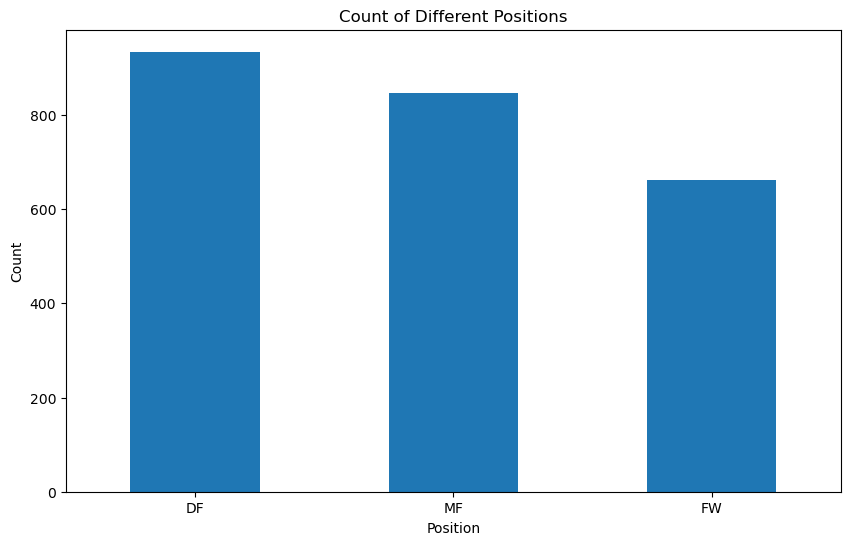

In [26]:
# Plot histogram count of positions
plt.figure(figsize=(10, 6))
df['Pos'].value_counts().plot(kind='bar')
plt.title('Count of Different Positions')
plt.xlabel('Position')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

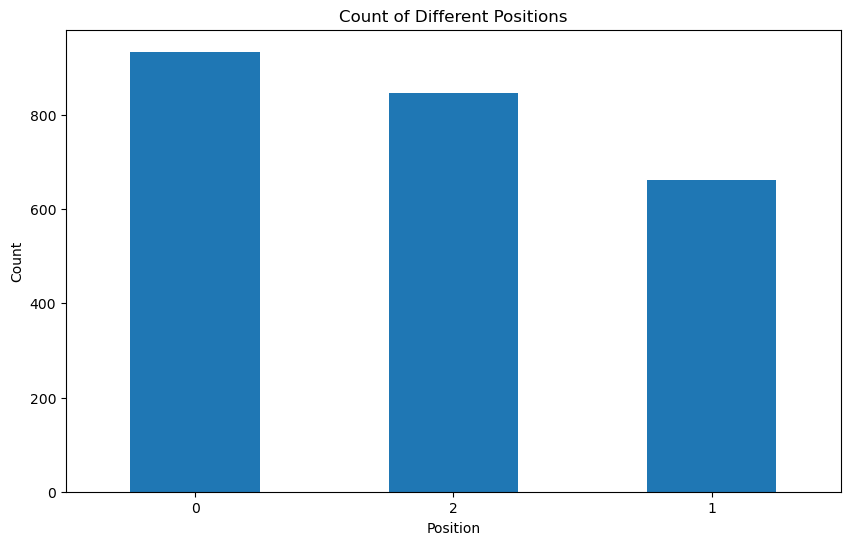

In [27]:
# Plot histogram count of positions
plt.figure(figsize=(10, 6))
scaled_numeric_df['Pos_Cat'].value_counts().plot(kind='bar')
plt.title('Count of Different Positions')
plt.xlabel('Position')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

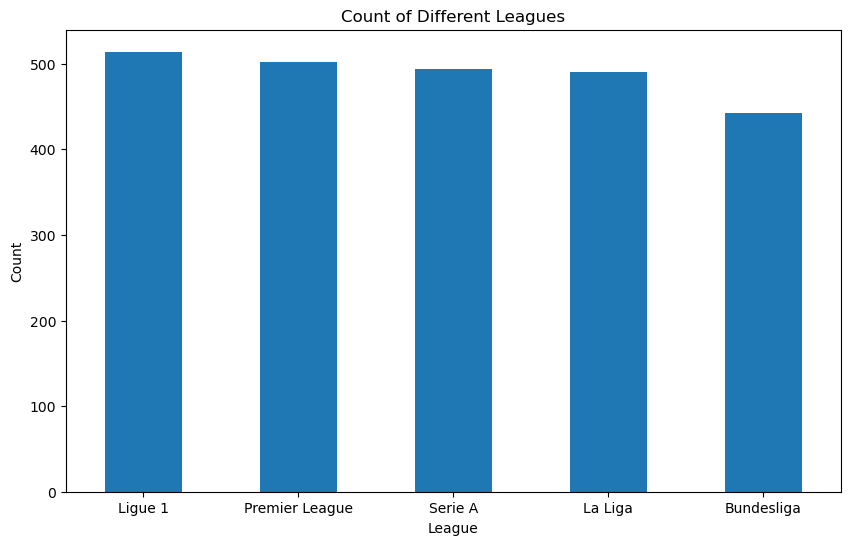

In [28]:
# Plot histogram count of positions
plt.figure(figsize=(10, 6))
df['Comp'].value_counts().plot(kind='bar')
plt.title('Count of Different Leagues')
plt.xlabel('League')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [29]:
# Calculate correlation matrix
correlation_matrix = scaled_numeric_df.corr()

# Print correlation matrix
correlation_matrix

,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
Market Value Euro,1.000000,0.139496,0.286923,0.339961,0.447905,0.138930,0.114982,0.144634,0.175860,0.103496,0.026574,0.126360,0.119067,0.152422,0.128769,0.118394,0.054653,0.192930,0.187349,0.089783,0.069318,0.051397,0.004786,0.094695,0.124825,0.141933,0.105950,-0.014645,0.126414,0.149271,-0.059583,-0.000013,0.095428,0.078359,-0.013871,-0.095378,0.060601,0.046472,0.032884,0.056888,0.152422,0.017317,0.003232,0.148642,0.147273,0.013270,0.047312,0.056478,0.047278,0.017430,0.123224,0.128193,0.034787,0.027716,0.014368,0.060754,0.026303,-0.063769,-0.046029,-0.080045,-0.018729,0.001787,-0.058137,-0.073487,-0.053830,-0.044953,-0.049256,-0.026375,-0.050954,-0.082104,0.004310,0.124593,-0.040529,-0.032732,0.102965,0.147748,0.173641,0.124255,0.100859,0.098222,0.064376,0.164953,0.151999,0.156601,0.128300,0.087597,0.161449,0.015450,0.025661,0.216255,0.120362,-0.047486,-0.016429,-0.005454,-0.073757,0.031064,0.029053,-0.013871,-0.046029,0.061557,-0.049369,0.038228,-0.016515,-0.060702,-0.104235,0.057258,-0.014103,-0.020786,0.082831
Born,0.139496,1.000000,-0.219287,-0.217304,-0.084163,0.048642,0.054472,-0.036739,-0.082920,-0.110296,-0.048457,-0.105874,-0.127398,-0.100614,-0.107997,-0.123007,-0.171264,-0.054289,-0.049524,-0.089243,-0.094921,-0.159137,-0.175395,0.012677,-0.033262,-0.140688,0.004268,0.016811,-0.084007,-0.097215,-0.076404,-0.168581,-0.035886,-0.093729,-0.025600,-0.002079,-0.055505,-0.026514,-0.053225,-0.047274,-0.100614,-0.058236,0.057462,0.015745,0.005904,-0.064729,0.080218,0.018640,0.015538,0.021442,0.036713,0.027021,-0.046472,0.021473,0.026961,0.004662,0.007615,0.101689,0.095614,0.063014,0.066310,0.069226,0.021690,0.031188,0.026043,0.042433,-0.088285,0.084789,0.002044,-0.112367,-0.000091,-0.062422,-0.123527,-0.087828,-0.074567,0.074987,0.070913,-0.062047,0.213889,0.152022,0.191722,-0.014245,0.073199,0.043913,0.118538,0.066069,0.133708,0.137467,0.163235,-0.057076,0.114659,0.037254,-0.015672,-0.001606,0.060290,0.059450,-0.036435,-0.025600,0.095614,0.028498,0.004077,-0.017087,0.042172,-0.065115,0.032218,0.063239,0.032719,0.058844,0.019184
MP,0.286923,-0.219287,1.000000,0.902420,0.429168,0.007898,0.010656,0.186783,0.319424,0.416243,0.021592,0.131650,0.132473,0.080269,0.071698,0.089369,0.105057,0.072729,0.066234,0.054403,0.050776,0.109708,0.099012,0.049261,0.053634,0.150813,0.018721,-0.016391,0.108769,0.068253,0.038052,0.106641,0.014790,0.068318,0.007866,-0.020039,0.059094,0.030133,0.050810,0.063162,0.080269,-0.005893,-0.037485,0.039512,0.058512,0.046364,-0.037763,-0.038077,0.015800,-0.003218,0.050016,0.068842,0.090817,-0.014629,-0.036997,0.083747,0.065143,-0.089202,-0.084074,-0.087999,-0.027413,-0.043588,-0.041572,-0.078187,-0.078408,-0.051998,-0.001319,-0.055274,0.021830,-0.020064,-0.000476,0.036141,0.008287,0.011816,0.068585,-0.028527,-0.009606,0.035765,-0.087579,-0.072909,-0.071425,0.060210,0.034872,0.043405,-0.016370,-0.021261,0.006910,-0.083156,-0.097736,0.064521,-0.040791,-0.099104,-0.042121,-0.042028,-0.110766,-0.009883,-0.032809,0.007866,-0.084074,0.086043,-0.016285,0.036022,0.004320,-0.039973,-0.126331,0.019049,-0.001515,-0.015897,0.041182
90s,0.339961,-0.217304,0.902420,1.000000,0.423576,-0.085998,-0.048441,0.161682,0.286378,0.339776,0.016248,0

In [30]:
import numpy as np
import pandas as pd

# Sample data: scaled_numeric_df is your dataframe with scaled numeric features

# Set the threshold for collinearity
threshold = 0.95

# Compute the correlation matrix
corr_matrix = scaled_numeric_df.corr().abs()

# Initialize the set of columns to keep
columns_to_keep = set(scaled_numeric_df.columns)

# Loop through the correlation matrix and identify columns to drop
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            # Check which column to drop based on the current set of columns to keep
            if colname_i in columns_to_keep and colname_j in columns_to_keep:
                # Drop one of the columns (e.g., column j)
                columns_to_keep.remove(colname_j)

# Create a new dataframe with only the selected columns
scaled_numeric_df = scaled_numeric_df[list(columns_to_keep)]

# Output the result
print(f"Dropped columns due to high correlation: {set(scaled_numeric_df.columns) - columns_to_keep}")
print(f"Remaining columns: {columns_to_keep}")

Dropped columns due to high correlation: set()
Remaining columns: {'AerLost', 'PasFK', 'AerWon', 'ScaPassDead', 'TouAttPen', 'GcaPassLive', 'TklMid3rd', 'Goals', 'PasProg', 'Rec', 'CarTotDist', 'TouMid3rd', 'Squad_Cat', 'G/Sh', 'TklDriPast', 'ScaPassLive', 'BlkSh', 'TouAtt3rd', 'RecProg', 'PasBlocks', 'TklDriAtt', 'ToSuc', 'PasShoCmp', 'Pos_Cat', 'PasLonAtt', 'PasMedCmp', 'Clr', 'PasTotCmp', 'Assists', 'GCA', 'Carries', 'Sw', 'PKcon', 'TouDefPen', 'CrsPA', 'TklDef3rd', 'ShoDist', 'OG', 'PasTotPrgDist', 'GcaSh', 'TB', 'Shots', 'CrdY', 'GcaDef', 'PKatt', 'GcaDrib', 'CkStr', 'TklDri', 'Market Value Euro', 'CK', 'Recov', 'GcaPassDead', 'Fld', 'TklWon', 'TouDef3rd', 'PasAss', 'ScaSh', 'Nation_Cat', 'GcaFld', 'ScaDrib', 'Tkl', 'BlkPass', 'Touches', 'Int', 'Blocks', 'PPA', 'CarPrgDist', 'Pas3rd', 'SoT', 'CarProg', 'ToAtt', 'CarDis', 'MP', 'PasLonCmp', 'PasDead', '90s', 'ShoPK', 'ToTkl', '2CrdY', 'Fls', 'TI', 'CkIn', 'CarMis', 'Car3rd', 'Off', 'Comp_Cat', 'PKwon', 'Err', 'PasCrs', 'CPA', 'SCA'

In [31]:
scaled_numeric_df.head()

,AerLost,PasFK,AerWon,ScaPassDead,TouAttPen,GcaPassLive,TklMid3rd,Goals,PasProg,Rec,CarTotDist,TouMid3rd,Squad_Cat,G/Sh,TklDriPast,ScaPassLive,BlkSh,TouAtt3rd,RecProg,PasBlocks,TklDriAtt,ToSuc,PasShoCmp,Pos_Cat,PasLonAtt,PasMedCmp,Clr,PasTotCmp,Assists,GCA,Carries,Sw,PKcon,TouDefPen,CrsPA,TklDef3rd,ShoDist,OG,PasTotPrgDist,GcaSh,TB,Shots,CrdY,GcaDef,PKatt,GcaDrib,CkStr,TklDri,Market Value Euro,CK,Recov,GcaPassDead,Fld,TklWon,TouDef3rd,PasAss,ScaSh,Nation_Cat,GcaFld,ScaDrib,Tkl,BlkPass,Touches,Int,Blocks,PPA,CarPrgDist,Pas3rd,SoT,CarProg,ToAtt,CarDis,MP,PasLonCmp,PasDead,90s,ShoPK,ToTkl,2CrdY,Fls,TI,CkIn,CarMis,Car3rd,Off,Comp_Cat,PKwon,Err,PasCrs,CPA,SCA,CrdR,TklAtt3rd,ScaDef,PasOff,ScaFld,Born,G/SoT,ShoFK,CkOut
0,2.410737,2.653478,1.926205,6.702429,2.752670,2.894737,2.896479,3.394737,2.353692,2.181322,2.155889,1.986866,44,2.758373,2.942682,3.012623,2.323308,2.910610,2.733389,2.416242,2.503264,3.207924,2.209170,2,1.934661,1.855241,1.977237,1.960646,3.311404,2.957237,2.155743,2.054311,2.394737,1.929233,2.787594,2.142105,2.720580,2.394737,1.935824,2.454737,3.702429,2.755496,2.261404,2.454737,2.394737,2.394737,2.454737,2.228070,4.061404,10.131579,2.310446,2.394737,3.498185,1.995815,1.895959,3.295638,2.973684,98,2.394737,4.485646,2.429702,3.603070,1.929825,1.720038,3.232237,2.262084,2.067622,2.159320,2.472862,2.495747,3.481546,4.257640,2.933198,1.894737,2.573721,3.297392,2.394737,3.394737,2.394737,1.864737,2.369259,3.074737,3.087474,2.387792,3.103070,3,2.394737,2.454737,3.052658,2.820966,3.180114,2.394737,2.818979,2.454737,2.019737,4.293042,2.823308,3.000797,2.504737,3.014737
1,2.442737,4.303828,3.212919,2.394737,2.236065,2.758373,3.035852,2.394737,2.831304,2.443517,3.082016,2.738207,73,2.394737,2.120764,2.030509,3.894737,1.420927,1.772396,2.136672,2.666055,2.251880,1.961747,0,2.814889,3.306502,3.292237,2.656100,2.811404,2.644737,2.992221,3.224524,2.394737,3.697239,2.394737,3.194737,2.102602,2.394737,3.271261,2.444737,2.394737,2.331446,2.194737,2.394737,2.394737,2.394737,2.394737,3.192356,2.036404,2.394737,2.992438,2.394737,1.980944,3.160235,3.405332,1.962304,3.342105,64,2.394737,2.394737,3.031100,3.422515,2.596491,3.589918,3.907237,1.894737,3.254607,2.642654,2.113487,2.000797,2.106124,2.297963,3.087045,2.791612,2.770026,3.677923,2.394737,2.226670,2.394737,2.564737,2.280087,2.394737,2.042782,1.804459,2.603070,2,2.394737,2.444737,2.100085,2.312770,2.010303,2.394737,2.122010,2.484737,2.978070,2.394737,0.966165,2.394737,2.394737,2.394737
2,2.298737,2.226905,2.338793,2.394737,2.261896,2.122010,3.593343,2.394737,3.540259,2.986200,3.689049,3.203324,2,2.394737,3.065970,3.058151,2.347118,2.585213,2.783035,2.749576,3.433497,4.196935,2.745252,2,2.611467,2.659443,2.302237,2.724282,2.394737,2.082237,3.526812,2.543673,2.394737,2.089960,3.644737,3.015789,2.743051,2.394737,2.523232,2.394737,3.317814,2.451699,2.294737,2.394737,2.394737,2.394737,2.394737,3.561404,2.186404,2.394737,3.567151,2.394737,2.653358,2.955384,2.355617,3.079422,3.026316,36,2.394737,2.394737,3.317814,3.353070,2.745614,2.558592,3.007237,3.578410,3.705800,3.075987,2.582237,3.015949,3.531152,2.596350,2.471660,2.994737,2.176492,2.492082,2.394737,3.193056,2.394737,2.984737,2.738686,2.394737,2.802558,3.422515,2.394737,2,2.394737,2.394737,2.451245,2.935720,2.732001,2.394737,2.667464,2.514737,2.978070,2.394737,2.680451,2.394737,2.394737,2.394737
3,1.858737,2.891240,2.038093,2.394737,2.092154,2.122010,2.826793,3.394737,3.241752,3.784981,3.862757,4.176490,46,3.122010,2.244052,2.349208,2.894737,2.172515,2.033035,1.932371,2.371481,2.669462,3.889582,2,2.301581,3.432552,2.237237,3.610646,2.394737,2.082237,4.312976,2.479843,2.394737,2.444775,2.751880,2.247368,2.866647,2.444737,2.745805,2.394737,2.779352,2.166889,2.394737,2.394737,2.394737,2.394737,2.394737,2.632832,3.061404,2.394737,2.977112,2.394737,2.713702,2.308483,2.394737,2.169512,2.921053,41,2.394737,3.303828,2.331800,2.728070,3.214912,2.722448,2.744737,2.364125,3.124455,3.930154,2.269737,2.354333,2.363170,2.797963,2.933198,2.660362,2

# Machine Learning

In [32]:
# Separate data for ML classification (Position)
X = scaled_numeric_df.drop(['Market Value Euro'], axis=1)
y_market_value_euro = scaled_numeric_df['Market Value Euro']

In [33]:
from sklearn.model_selection import train_test_split

X_train_mv, X_test_mv, y_train_mv, y_test_mv = train_test_split(X, y_market_value_euro, test_size=0.2)

## Random Forest Train and Test

In [34]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor
rf_market_value = RandomForestRegressor(n_estimators=100)

# Train the Random Forest regressor with the training data
rf_market_value.fit(X_train_mv, y_train_mv)

RandomForestRegressor()

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict the Market Value Euro using the test data
y_pred_mv = rf_market_value.predict(X_test_mv)

# Evaluate the performance
mae = mean_absolute_error(y_test_mv, y_pred_mv)
mse = mean_squared_error(y_test_mv, y_pred_mv)
r2 = r2_score(y_test_mv, y_pred_mv)

print("Evaluation Metrics for Market Value Euro Prediction:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Evaluation Metrics for Market Value Euro Prediction:
Mean Absolute Error (MAE): 0.5914661724608041
Mean Squared Error (MSE): 0.8413445953405475
R² Score: 0.4066970234959465


## Hyperparameter Tuning for RF

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_mv, y_train_mv)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf_market_value = grid_search.best_estimator_

# Evaluate the best model
y_pred_best_mv = best_rf_market_value.predict(X_test_mv)

# Evaluate the performance
mae_best = mean_absolute_error(y_test_mv, y_pred_best_mv)
mse_best = mean_squared_error(y_test_mv, y_pred_best_mv)
r2_best = r2_score(y_test_mv, y_pred_best_mv)

print("Evaluation Metrics for Best Model - Market Value Euro Prediction:")
print(f"Mean Absolute Error (MAE): {mae_best}")
print(f"Mean Squared Error (MSE): {mse_best}")
print(f"R² Score: {r2_best}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Evaluation Metrics for Best Model - Market Value Euro Prediction:
Mean Absolute Error (MAE): 0.5746809956697897
Mean Squared Error (MSE): 0.8067135004557259
R² Score: 0.4311183269529948


## Feature importance analysis

Total number of features used for training/testing: 99
Evaluation Metrics for Best Model with Top 99 Features:
Mean Absolute Error (MAE): 0.5784665551567646
Mean Squared Error (MSE): 0.8195108369044628
R² Score: 0.42209384655767446


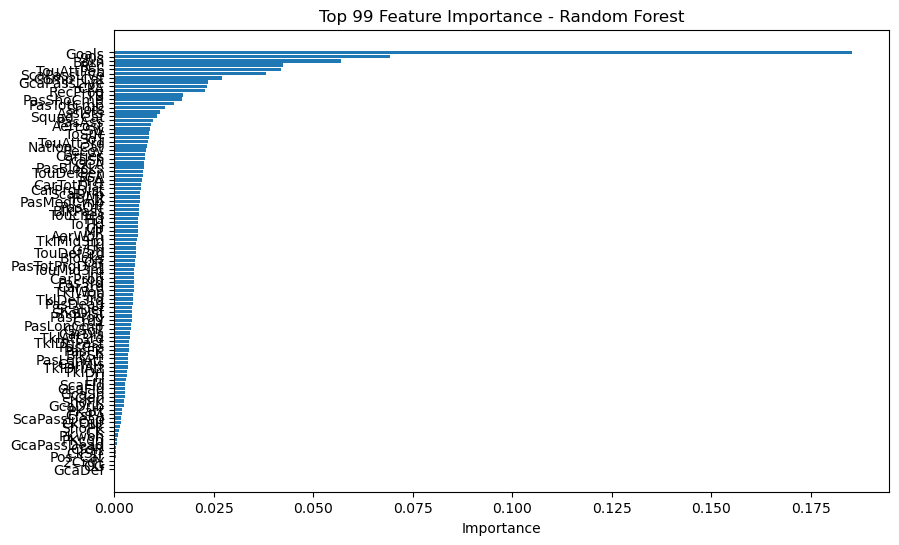

Total number of features used for training/testing: 98
Evaluation Metrics for Best Model with Top 98 Features:
Mean Absolute Error (MAE): 0.5790310246662751
Mean Squared Error (MSE): 0.8301668669129956
R² Score: 0.4145793817868869


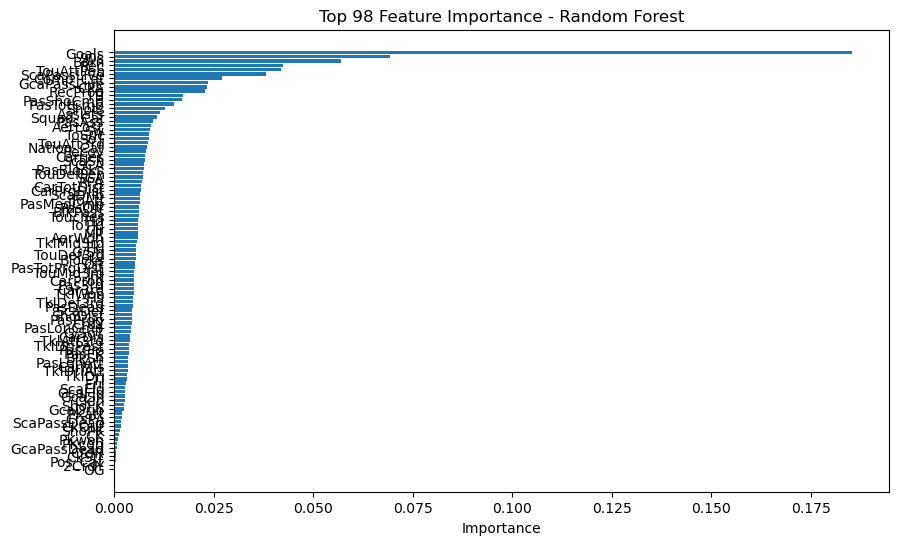

Total number of features used for training/testing: 97
Evaluation Metrics for Best Model with Top 97 Features:
Mean Absolute Error (MAE): 0.5791104400880825
Mean Squared Error (MSE): 0.8263241980713886
R² Score: 0.4172891714189485


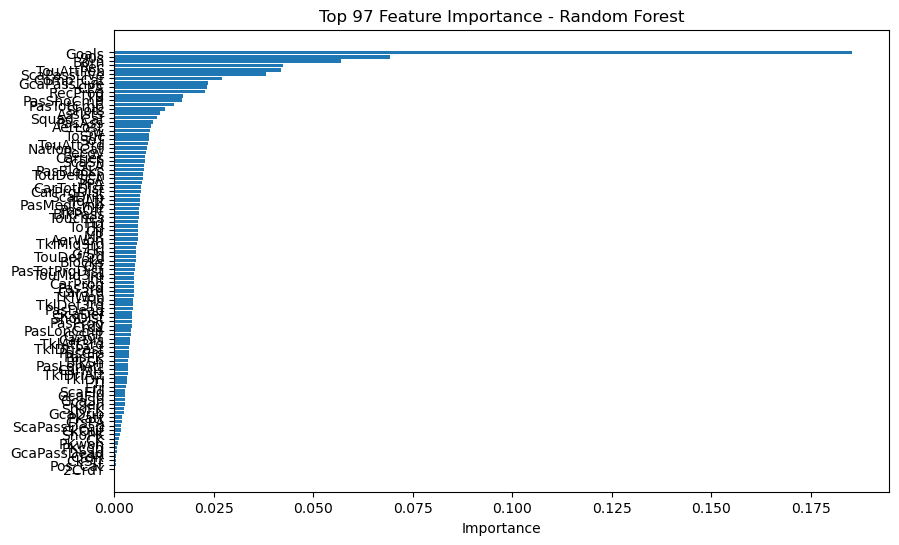

Performance change is less than the tolerance (0.01), continuing to test lower feature counts...

Performance Metrics Across Feature Reductions:
    feature_count       mae       mse        r2
0              99  0.578467  0.819511  0.422094
1              98  0.579031  0.830167  0.414579
2              97  0.579110  0.826324  0.417289
3              96  0.575954  0.817195  0.423727
4              95  0.579902  0.835418  0.410877
5              94  0.578168  0.821581  0.420634
6              93  0.577738  0.824486  0.418585
7              92  0.582229  0.836884  0.409843
8              91  0.579814  0.827900  0.416178
9              90  0.578436  0.833139  0.412483
10             89  0.575248  0.818180  0.423032
11             88  0.577015  0.825494  0.417875
12             87  0.577344  0.823055  0.419595
13             86  0.578726  0.830497  0.414347
14             85  0.578831  0.830619  0.414261
15             84  0.577732  0.828574  0.415703
16             83  0.580586  0.832590  

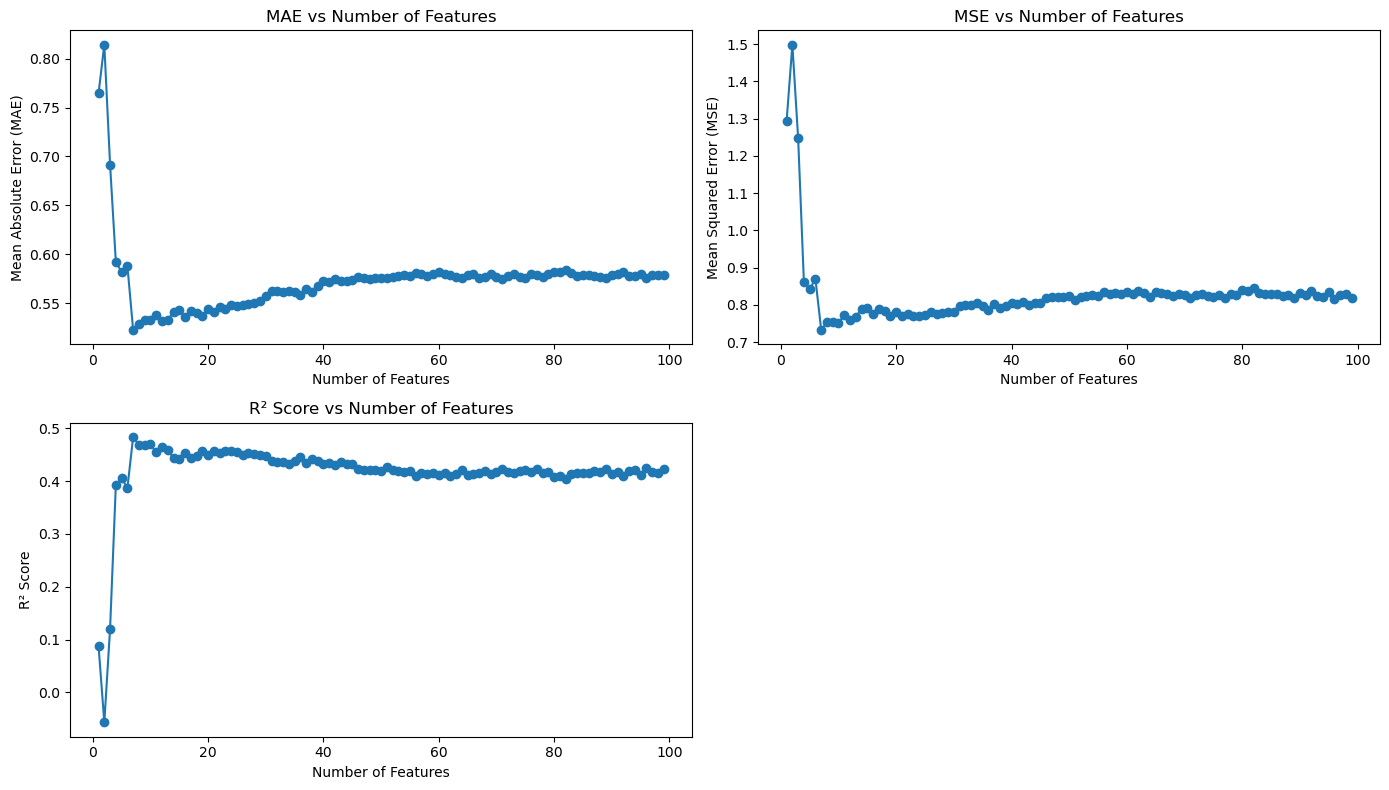

In [37]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the best parameters
best_params = {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

# Train the RandomForestRegressor with the best parameters
best_rf_market_value = RandomForestRegressor(**best_params, random_state=42)
best_rf_market_value.fit(X_train_mv, y_train_mv)

# Extract feature importances
importances = best_rf_market_value.feature_importances_
feature_names = X_train_mv.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Initialize variables for iteration
previous_performance = None
tolerance = 0.01  # Threshold for change in performance to stop iteration
min_features = 1  # Minimum number of features to use

# Initialize a dictionary to store performance metrics
performance_metrics = {
    'feature_count': [],
    'mae': [],
    'mse': [],
    'r2': []
}

# Loop to reduce features
for n in range(len(feature_names), min_features - 1, -1):
    # Select top n features
    top_n_features = feature_importances.head(n)['Feature'].values

    # Filter the training and test sets to include only the top n features
    X_train_top_n = X_train_mv[top_n_features]
    X_test_top_n = X_test_mv[top_n_features]

    # Train the RandomForestRegressor on the top n features
    best_rf_market_value_top_n = RandomForestRegressor(**best_params, random_state=42)
    best_rf_market_value_top_n.fit(X_train_top_n, y_train_mv)

    # Predict on the test set with top n features
    y_pred_best_top_n = best_rf_market_value_top_n.predict(X_test_top_n)

    # Calculate performance metrics
    current_mae = mean_absolute_error(y_test_mv, y_pred_best_top_n)
    current_mse = mean_squared_error(y_test_mv, y_pred_best_top_n)
    current_r2 = r2_score(y_test_mv, y_pred_best_top_n)

    # Store performance metrics
    performance_metrics['feature_count'].append(n)
    performance_metrics['mae'].append(current_mae)
    performance_metrics['mse'].append(current_mse)
    performance_metrics['r2'].append(current_r2)

    # Print evaluation metrics
    print(f'Total number of features used for training/testing: {n}')
    print(f"Evaluation Metrics for Best Model with Top {n} Features:")
    print(f"Mean Absolute Error (MAE): {current_mae}")
    print(f"Mean Squared Error (MSE): {current_mse}")
    print(f"R² Score: {current_r2}")

    # Plot the top n features
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_features, feature_importances[feature_importances['Feature'].isin(top_n_features)]['Importance'], align='center')
    plt.xlabel('Importance')
    plt.title(f'Top {n} Feature Importance - Random Forest')
    plt.gca().invert_yaxis()
    plt.show()

    # Check if performance improvement is less than the tolerance
    if previous_performance is not None:
        if (abs(current_mae - previous_performance['mae']) < tolerance and
            abs(current_mse - previous_performance['mse']) < tolerance and
            abs(current_r2 - previous_performance['r2']) < tolerance):
            # Test additional features beyond the stopping point
            print(f"Performance change is less than the tolerance ({tolerance}), continuing to test lower feature counts...")
            # Test features below the current stopping point
            for test_n in range(n - 1, min_features - 1, -1):
                top_test_features = feature_importances.head(test_n)['Feature'].values
                X_train_test = X_train_mv[top_test_features]
                X_test_test = X_test_mv[top_test_features]
                model = RandomForestRegressor(**best_params, random_state=42)
                model.fit(X_train_test, y_train_mv)
                y_pred_test = model.predict(X_test_test)
                mae_test = mean_absolute_error(y_test_mv, y_pred_test)
                mse_test = mean_squared_error(y_test_mv, y_pred_test)
                r2_test = r2_score(y_test_mv, y_pred_test)
                performance_metrics['feature_count'].append(test_n)
                performance_metrics['mae'].append(mae_test)
                performance_metrics['mse'].append(mse_test)
                performance_metrics['r2'].append(r2_test)
            break

    # Update previous performance metrics
    previous_performance = {
        'mae': current_mae,
        'mse': current_mse,
        'r2': current_r2
    }

# Convert performance metrics to DataFrame for easier analysis
performance_df = pd.DataFrame(performance_metrics)
print("\nPerformance Metrics Across Feature Reductions:")
print(performance_df)

# Plot the performance metrics
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(performance_df['feature_count'], performance_df['mae'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs Number of Features')

plt.subplot(2, 2, 2)
plt.plot(performance_df['feature_count'], performance_df['mse'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Number of Features')

plt.subplot(2, 2, 3)
plt.plot(performance_df['feature_count'], performance_df['r2'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('R² Score vs Number of Features')

plt.tight_layout()
plt.show()


Performance Metrics for Model with Top 8 Features:
Mean Absolute Error (MAE): 0.5289572436306971
Mean Squared Error (MSE): 0.7538840149135996
R-squared (R²): 0.4683728492889164


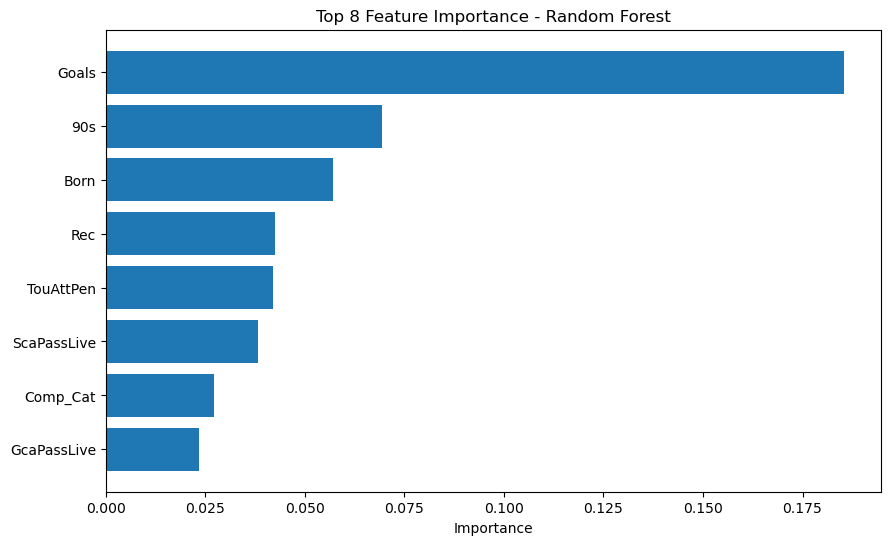

In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the best parameters for the RandomForestRegressor
best_params = {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

# Initialize and fit the RandomForestRegressor with all features
rf_regressor = RandomForestRegressor(**best_params, random_state=42)
rf_regressor.fit(X_train_mv, y_train_mv)

# Extract feature importances
importances = rf_regressor.feature_importances_
feature_names = X_train_mv.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Select the top 8 features based on importance
top_n_features = feature_importances.head(8)['Feature'].values

# Filter the training and test sets to include only the top 8 features
X_train_top_8 = X_train_mv[top_n_features]
X_test_top_8 = X_test_mv[top_n_features]

# Train the RandomForestRegressor on the top 8 features
best_rf_regressor = RandomForestRegressor(**best_params, random_state=42)
best_rf_regressor.fit(X_train_top_8, y_train_mv)

# Predict on the test set with the top 8 features
y_pred_best_top_8 = best_rf_regressor.predict(X_test_top_8)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_best_top_8)
mse = mean_squared_error(y_test_mv, y_pred_best_top_8)
r2 = r2_score(y_test_mv, y_pred_best_top_8)

# Print performance metrics
print(f"Performance Metrics for Model with Top 8 Features:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_n_features, feature_importances[feature_importances['Feature'].isin(top_n_features)]['Importance'], align='center')
plt.xlabel('Importance')
plt.title('Top 8 Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.show()


# Other models and best parameters

## Logistic regression

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Initialize the Linear Regression model
lr_regressor = LinearRegression()

# Fit the model on the training data
lr_regressor.fit(X_train_mv, y_train_mv)

# Predict on the test set
y_pred_lr = lr_regressor.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_lr)
mse = mean_squared_error(y_test_mv, y_pred_lr)
r2 = r2_score(y_test_mv, y_pred_lr)

# Print performance metrics
print("Linear Regression Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# # Optional: Display coefficients (if you want to see the importance of each feature)
# coefficients = pd.DataFrame({
#     'Feature': X_train_mv.columns,
#     'Coefficient': lr_regressor.coef_
# }).sort_values(by='Coefficient', ascending=False)

# print("\nLinear Regression Coefficients:")
# print(coefficients)


Linear Regression Performance Metrics:
Mean Absolute Error (MAE): 0.6786263671332182
Mean Squared Error (MSE): 1.0416447087851999
R-squared (R²): 0.2654485336869521


In [40]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the parameter grid
param_grid = {
    'fit_intercept': [True, False]  # Whether to calculate the intercept or not
}

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train_mv, y_train_mv)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert negative MSE to positive

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Mean Squared Error (MSE): {best_score:.4f}")

# Use the best estimator to make predictions
best_lr_model = grid_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_lr)
mse = mean_squared_error(y_test_mv, y_pred_lr)
r2 = r2_score(y_test_mv, y_pred_lr)

# Print performance metrics
print("Performance Metrics for Best Linear Regression Model:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# # Optional: Display coefficients (if you want to see the importance of each feature)
# coefficients = pd.DataFrame({
#     'Feature': X_train_mv.columns,
#     'Coefficient': best_lr_model.coef_
# }).sort_values(by='Coefficient', ascending=False)

# print("\nLinear Regression CoefCficients:")
# print(coefficients)


Best Parameters Found:
{'fit_intercept': True}
Best Cross-Validation Mean Squared Error (MSE): 1.3809
Performance Metrics for Best Linear Regression Model:
Mean Absolute Error (MAE): 0.6786
Mean Squared Error (MSE): 1.0416
R-squared (R²): 0.2654


In [41]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Top 8 features
top_8_features = ['Goals', '90s', 'Born', 'Rec', 'Comp_Cat', 'TouAttPen', 'CPA', 'ScaPassLive']

# Filter the training and test sets to include only the top 8 features
X_train_top_8 = X_train_mv[top_8_features]
X_test_top_8 = X_test_mv[top_8_features]

# Define the best parameters for Linear Regression
best_lr_params = {'fit_intercept': True}

# Initialize the Linear Regression model with the best parameters
best_lr_model = LinearRegression(**best_lr_params)

# Train the Linear Regression model with the best parameters
best_lr_model.fit(X_train_top_8, y_train_mv)

# Predict on the test set with top 8 features
y_pred_best_top_8 = best_lr_model.predict(X_test_top_8)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_best_top_8)
mse = mean_squared_error(y_test_mv, y_pred_best_top_8)
r2 = r2_score(y_test_mv, y_pred_best_top_8)

# Print performance metrics
print("Performance Metrics for Best Linear Regression Model with Top 8 Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Optional: Display coefficients (if you want to see the importance of each feature)
coefficients = pd.DataFrame({
    'Feature': top_8_features,
    'Coefficient': best_lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nLinear Regression Coefficients with Top 8 Features:")
print(coefficients)


Performance Metrics for Best Linear Regression Model with Top 8 Features:
Mean Absolute Error (MAE): 0.6675
Mean Squared Error (MSE): 1.0345
R-squared (R²): 0.2705

Linear Regression Coefficients with Top 8 Features:
       Feature  Coefficient
1          90s     0.511358
2         Born     0.464587
3          Rec     0.313792
0        Goals     0.260525
4     Comp_Cat     0.059089
6          CPA     0.057326
5    TouAttPen     0.029563
7  ScaPassLive     0.021706


## KNN

In [42]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the K-Nearest Neighbors Regressor with a specified number of neighbors
knn_model = KNeighborsRegressor(n_neighbors=5)

# Fit the model to the training data
knn_model.fit(X_train_mv, y_train_mv)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_knn)
mse = mean_squared_error(y_test_mv, y_pred_knn)
r2 = r2_score(y_test_mv, y_pred_knn)

# Print performance metrics
print("K-Nearest Neighbors Regression Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


K-Nearest Neighbors Regression Performance Metrics:
Mean Absolute Error (MAE): 0.7831
Mean Squared Error (MSE): 1.3733
R-squared (R²): 0.0315


In [43]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 21)),  # Number of neighbors to test
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for the Minkowski distance metric (1 for Manhattan, 2 for Euclidean)
}

# Initialize the K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train_mv, y_train_mv)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert negative MSE to positive MSE

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Mean Squared Error (MSE): {best_score:.4f}")

# Use the best estimator to make predictions
best_knn_model = grid_search.best_estimator_
y_pred_knn = best_knn_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_knn)
mse = mean_squared_error(y_test_mv, y_pred_knn)
r2 = r2_score(y_test_mv, y_pred_knn)

# Print performance metrics
print("Performance Metrics for Best KNN Regression Model:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Best Parameters Found:
{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Mean Squared Error (MSE): 1.4704
Performance Metrics for Best KNN Regression Model:
Mean Absolute Error (MAE): 0.6997
Mean Squared Error (MSE): 1.1625
R-squared (R²): 0.1803


In [44]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming top_8_features contains the top 8 features
top_8_features = ['Goals', '90s', 'Born', 'Rec', 'Comp_Cat', 'TouAttPen', 'CPA', 'ScaPassLive']

# Filter the training and test sets to include only the top 8 features
X_train_top_8 = X_train_mv[top_8_features]
X_test_top_8 = X_test_mv[top_8_features]

# Define the best parameters for K-Nearest Neighbors Regressor
best_knn_params = {'n_neighbors': 13, 'p': 1, 'weights': 'distance'}

# Initialize and train the K-Nearest Neighbors Regressor with the best parameters
best_knn_model = KNeighborsRegressor(**best_knn_params)
best_knn_model.fit(X_train_top_8, y_train_mv)

# Predict on the test set with top 8 features
y_pred_knn = best_knn_model.predict(X_test_top_8)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_knn)
mse = mean_squared_error(y_test_mv, y_pred_knn)
r2 = r2_score(y_test_mv, y_pred_knn)

# Print performance metrics
print("Performance Metrics for Best KNN Regression Model with Top 8 Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Performance Metrics for Best KNN Regression Model with Top 8 Features:
Mean Absolute Error (MAE): 0.5443
Mean Squared Error (MSE): 0.8246
R-squared (R²): 0.4185


## Gradient Boosting

In [45]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on the full training data
gb_model.fit(X_train_mv, y_train_mv)

# Predict on the full test data
y_pred_gb = gb_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_gb)
mse = mean_squared_error(y_test_mv, y_pred_gb)
r2 = r2_score(y_test_mv, y_pred_gb)

# Print performance metrics
print("Performance Metrics for Gradient Boosting Regressor with All Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Performance Metrics for Gradient Boosting Regressor with All Features:
Mean Absolute Error (MAE): 0.5326
Mean Squared Error (MSE): 0.7120
R-squared (R²): 0.4979


In [46]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinking to prevent overfitting
    'max_depth': [3, 5, 7],                # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]          # Minimum number of samples required to be at a leaf node
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train_mv, y_train_mv)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert back from negative MSE to positive MSE

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Mean Squared Error (MSE): {best_score:.4f}")

# Use the best estimator to make predictions
best_gb_model = grid_search.best_estimator_
y_pred_gb = best_gb_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_gb)
mse = mean_squared_error(y_test_mv, y_pred_gb)
r2 = r2_score(y_test_mv, y_pred_gb)

# Print performance metrics
print("Performance Metrics for Best Gradient Boosting Regressor:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


C:\Users\firda\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters Found:
{'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Mean Squared Error (MSE): 0.8457
Performance Metrics for Best Gradient Boosting Regressor:
Mean Absolute Error (MAE): 0.5552
Mean Squared Error (MSE): 0.7281
R-squared (R²): 0.4866


In [47]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming top_8_features contains the top 8 features
top_8_features = ['Goals', '90s', 'Born', 'Rec', 'Comp_Cat', 'TouAttPen', 'CPA', 'ScaPassLive']

# Filter the training and test sets to include only the top 8 features
X_train_top_8 = X_train_mv[top_8_features]
X_test_top_8 = X_test_mv[top_8_features]

# Define the best parameters for Gradient Boosting
best_gb_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100
}

# Train the Gradient Boosting Regressor with the best parameters
best_gb_mv_top_8 = GradientBoostingRegressor(**best_gb_params)
best_gb_mv_top_8.fit(X_train_top_8, y_train_mv)

# Predict on the test set with top 8 features
y_pred_best_top_8 = best_gb_mv_top_8.predict(X_test_top_8)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_best_top_8)
mse = mean_squared_error(y_test_mv, y_pred_best_top_8)
r2 = r2_score(y_test_mv, y_pred_best_top_8)

# Print performance metrics
print("Performance Metrics for Best Gradient Boosting Regressor with Top 8 Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Performance Metrics for Best Gradient Boosting Regressor with Top 8 Features:
Mean Absolute Error (MAE): 0.5185
Mean Squared Error (MSE): 0.7350
R-squared (R²): 0.4817


## Xtreme Gradient Boosting

In [48]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Train the model on the full training data
xgb_model.fit(X_train_mv, y_train_mv)

# Predict on the full test data
y_pred_xgb = xgb_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_xgb)
mse = mean_squared_error(y_test_mv, y_pred_xgb)
r2 = r2_score(y_test_mv, y_pred_xgb)

# Print performance metrics
print("Performance Metrics for XGBoost Regressor with All Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Performance Metrics for XGBoost Regressor with All Features:
Mean Absolute Error (MAE): 0.5922
Mean Squared Error (MSE): 0.9074
R-squared (R²): 0.3601


In [49]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinking to prevent overfitting
    'max_depth': [3, 5, 7],               # Maximum depth of the individual trees
    'min_child_weight': [1, 3, 5],        # Minimum sum of instance weight (hessian) needed in a child
    'gamma': [0, 0.1, 0.3],               # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': [0.8, 1.0],              # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0]        # Subsample ratio of columns when constructing each tree
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train_mv, y_train_mv)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Mean Squared Error (MSE): {best_score:.4f}")

# Use the best estimator to make predictions
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_xgb)
mse = mean_squared_error(y_test_mv, y_pred_xgb)
r2 = r2_score(y_test_mv, y_pred_xgb)

# Print performance metrics
print("Performance Metrics for Best XGBoost Regressor:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Best Parameters Found:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Best Cross-Validation Mean Squared Error (MSE): -0.8363
Performance Metrics for Best XGBoost Regressor:
Mean Absolute Error (MAE): 0.5302
Mean Squared Error (MSE): 0.7094
R-squared (R²): 0.4997


In [50]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming top_n_features contains the top 8 features
top_n_features = ['Goals', '90s', 'Born', 'Rec', 'Comp_Cat', 'TouAttPen', 'CPA', 'ScaPassLive']

# Filter the training and test sets to include only the top 8 features
X_train_top_8 = X_train_mv[top_n_features]
X_test_top_8 = X_test_mv[top_n_features]

# Define the best parameters for XGBoost
best_xgb_params = {
    'colsample_bytree': 1.0,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 3,
    'n_estimators': 200,
    'subsample': 0.8
}

# Train the XGBoost model with the best parameters
best_xgb_mv_top_8 = XGBRegressor(**best_xgb_params)
best_xgb_mv_top_8.fit(X_train_top_8, y_train_mv)

# Predict on the test set with top 8 features
y_pred_best_top_8 = best_xgb_mv_top_8.predict(X_test_top_8)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_best_top_8)
mse = mean_squared_error(y_test_mv, y_pred_best_top_8)
r2 = r2_score(y_test_mv, y_pred_best_top_8)

# Print performance metrics
print("Performance Metrics for Best XGBoost Regressor with Top 8 Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Performance Metrics for Best XGBoost Regressor with Top 8 Features:
Mean Absolute Error (MAE): 0.5273
Mean Squared Error (MSE): 0.6929
R-squared (R²): 0.5114


## Neural Network

In [51]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the MLP Regressor model
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Train the model on the full training data
mlp_model.fit(X_train_mv, y_train_mv)

# Predict on the full test data
y_pred_mlp = mlp_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_mlp)
mse = mean_squared_error(y_test_mv, y_pred_mlp)
r2 = r2_score(y_test_mv, y_pred_mlp)

# Print performance metrics
print("Performance Metrics for Neural Network (MLP) Regressor with All Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Performance Metrics for Neural Network (MLP) Regressor with All Features:
Mean Absolute Error (MAE): 0.7754
Mean Squared Error (MSE): 1.2241
R-squared (R²): 0.1368


In [52]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid for MLPRegressor
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50)],  # Different layer sizes
    'activation': ['tanh', 'relu'],  # Activation functions
    'solver': ['sgd', 'adam'],  # Solvers
    'alpha': [0.0001, 0.001, 0.01],  # Regularization term
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'max_iter': [200, 500, 1000]  # Number of iterations
}

# Initialize the MLPRegressor
mlp_model = MLPRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train_mv, y_train_mv)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Mean Squared Error (MSE): {best_score:.4f}")

# Use the best estimator to make predictions
best_mlp_model = grid_search.best_estimator_
y_pred_mlp = best_mlp_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_mlp)
mse = mean_squared_error(y_test_mv, y_pred_mlp)
r2 = r2_score(y_test_mv, y_pred_mlp)

# Print performance metrics
print("Performance Metrics for Best MLP Regressor:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Best Parameters Found:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Best Cross-Validation Mean Squared Error (MSE): -1.2617
Performance Metrics for Best MLP Regressor:
Mean Absolute Error (MAE): 0.6782
Mean Squared Error (MSE): 0.9758
R-squared (R²): 0.3119


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming top_n_features contains the top 8 features
top_n_features = ['Goals', '90s', 'Born', 'Rec', 'Comp_Cat', 'TouAttPen', 'CPA', 'ScaPassLive']

# Filter the training and test sets to include only the top 8 features
X_train_top_8 = X_train_mv[top_n_features]
X_test_top_8 = X_test_mv[top_n_features]

# Define the best parameters for MLP Regressor
best_mlp_params = {
    'activation': 'tanh',
    'alpha': 0.01,
    'hidden_layer_sizes': (150,),
    'learning_rate': 'adaptive',
    'max_iter': 1000,
    'solver': 'sgd'
}

# Train the MLP Regressor model with the best parameters
best_mlp_mv_top_8 = MLPRegressor(**best_mlp_params)
best_mlp_mv_top_8.fit(X_train_top_8, y_train_mv)

# Predict on the test set with top 8 features
y_pred_best_top_8 = best_mlp_mv_top_8.predict(X_test_top_8)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_best_top_8)
mse = mean_squared_error(y_test_mv, y_pred_best_top_8)
r2 = r2_score(y_test_mv, y_pred_best_top_8)

# Print performance metrics
print("Performance Metrics for Best MLP Regressor with Top 8 Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Performance Metrics for Best MLP Regressor with Top 8 Features:
Mean Absolute Error (MAE): 0.6206
Mean Squared Error (MSE): 0.8785
R-squared (R²): 0.3805


## Naive Bayes

In [54]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Filter the training and test sets to include all features
X_train_all = X_train_mv
X_test_all = X_test_mv

# Define the kernel for Gaussian Process Regressor
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))

# Initialize the Gaussian Process Regressor with the defined kernel
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Train the model on the full training data
gp_model.fit(X_train_all, y_train_mv)

# Predict on the full test data
y_pred_gp = gp_model.predict(X_test_all)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_gp)
mse = mean_squared_error(y_test_mv, y_pred_gp)
r2 = r2_score(y_test_mv, y_pred_gp)

# Print performance metrics
print("Performance Metrics for Gaussian Process Regressor with All Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Optionally, print the kernel used
print(f"Kernel Used: {gp_model.kernel_}")


Performance Metrics for Gaussian Process Regressor with All Features:
Mean Absolute Error (MAE): 0.9001
Mean Squared Error (MSE): 1.5325
R-squared (R²): -0.0807
Kernel Used: 2.93**2 * RBF(length_scale=11.2)


In [55]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid for GaussianProcessRegressor
param_grid = {
    'kernel': [C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))],  # Example kernel, customize if needed
    'alpha': [1e-2, 1e-3, 1e-4]  # Variance of the Gaussian noise
}

# Initialize the GaussianProcessRegressor
gp_model = GaussianProcessRegressor()

# Define a custom scorer for regression
def mean_squared_error_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return -mean_squared_error(y, y_pred)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gp_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=mean_squared_error_scorer)

# Fit GridSearchCV
grid_search.fit(X_train_mv, y_train_mv)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Mean Squared Error (MSE): {best_score:.4f}")

# Use the best estimator to make predictions
best_gp_model = grid_search.best_estimator_
y_pred_gp = best_gp_model.predict(X_test_mv)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_gp)
mse = mean_squared_error(y_test_mv, y_pred_gp)
r2 = r2_score(y_test_mv, y_pred_gp)

# Print performance metrics
print("Performance Metrics for Best Gaussian Process Regressor:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Optionally, print the kernel used
print(f"Kernel Used: {best_gp_model.kernel_}")


Best Parameters Found:
{'alpha': 0.01, 'kernel': 1**2 * RBF(length_scale=1)}
Best Cross-Validation Mean Squared Error (MSE): 2.0627
Performance Metrics for Best Gaussian Process Regressor:
Mean Absolute Error (MAE): 0.9001
Mean Squared Error (MSE): 1.5325
R-squared (R²): -0.0807
Kernel Used: 2.93**2 * RBF(length_scale=11.2)


In [56]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the top 8 features
top_n_features = ['Goals', '90s', 'Born', 'Rec', 'Comp_Cat', 'TouAttPen', 'CPA', 'ScaPassLive']

# Filter the training and test sets to include only the top 8 features
X_train_top_8 = X_train_mv[top_n_features]
X_test_top_8 = X_test_mv[top_n_features]

# Define the kernel and alpha parameters
kernel = C(2.83, (1e-2, 1e2)) * RBF(length_scale=10.8, length_scale_bounds=(1e-2, 1e2))
alpha = 0.01

# Initialize the GaussianProcessRegressor with the best parameters
best_gp_mv_top_8 = GaussianProcessRegressor(kernel=kernel, alpha=alpha)

# Train the Gaussian Process Regressor model with the top 8 features
best_gp_mv_top_8.fit(X_train_top_8, y_train_mv)

# Predict on the test set with top 8 features
y_pred_best_top_8 = best_gp_mv_top_8.predict(X_test_top_8)

# Calculate performance metrics
mae = mean_absolute_error(y_test_mv, y_pred_best_top_8)
mse = mean_squared_error(y_test_mv, y_pred_best_top_8)
r2 = r2_score(y_test_mv, y_pred_best_top_8)

# Print performance metrics
print("Performance Metrics for Best Gaussian Process Regressor with Top 8 Features:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Optionally, print the kernel used
print(f"Kernel Used: {best_gp_mv_top_8.kernel_}")


Performance Metrics for Best Gaussian Process Regressor with Top 8 Features:
Mean Absolute Error (MAE): 0.9461
Mean Squared Error (MSE): 2.1643
R-squared (R²): -0.5263
Kernel Used: 2.68**2 * RBF(length_scale=0.744)


In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the best parameters for each model
best_params = {
    'RandomForest': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},
    'GradientBoosting': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1},
    'XGBoost': {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8},
    'KNN': {'n_neighbors': 5, 'p': 1, 'weights': 'distance'},
    'LinearRegression': {},  # LinearRegression has no hyperparameters in GridSearch
    'MLP': {'hidden_layer_sizes': (100,), 'max_iter': 500},
    'NaiveBayes': {'var_smoothing': 1e-05},  # This is not suitable for regression, so it's excluded
    'GaussianProcess': {'kernel': C(2.83, (1e-2, 1e2)) * RBF(length_scale=10.8, length_scale_bounds=(1e-2, 1e2)), 'alpha': 0.01}
}

# Define the models
models = {
    'RandomForest': RandomForestRegressor(**best_params['RandomForest'], random_state=42),
    'GradientBoosting': GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=42),
    'XGBoost': XGBRegressor(**best_params['XGBoost'], random_state=42),
    'KNN': KNeighborsRegressor(**best_params['KNN']),
    'LinearRegression': LinearRegression(),  # No parameters to set
    'MLP': MLPRegressor(**best_params['MLP'], random_state=42),
    'GaussianProcess': GaussianProcessRegressor(**best_params['GaussianProcess'])
}

# Define the number of splits for K-Fold
num_splits = 5

# Perform nested cross-validation
kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)

# Replace 'X_train_top_42' and 'y_train_pos' with your actual top 8 features and target variable
# Define top 8 features for demonstration
top_n_features = ['Goals', '90s', 'Born', 'Rec', 'Comp_Cat', 'TouAttPen', 'CPA', 'ScaPassLive']
X_train_top_8 = X_train_mv[top_n_features]
X_test_top_8 = X_test_mv[top_n_features]
y_train_mv = y_train_mv  # Define your target variable for regression
y_test_mv = y_test_mv    # Define your target variable for regression

for model_name, model in models.items():
    print(f"Running Nested CV for {model_name}")
    
    # Inner CV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid={key: [val] for key, val in best_params.get(model_name, {}).items()}, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Outer CV for model evaluation
    nested_cv_scores = cross_val_score(grid_search, X_train_top_8, y_train_mv, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    
    print(f"Best Cross-Validation Mean Squared Error (MSE) for {model_name}: {-nested_cv_scores.mean():.4f} ± {-nested_cv_scores.std():.4f}")
    
    # Fit the best model on the entire training set
    grid_search.fit(X_train_top_8, y_train_mv)
    best_model = grid_search.best_estimator_
    
    # Test the best model on the test set
    y_pred = best_model.predict(X_test_top_8)
    
    # Calculate performance metrics
    mae = mean_absolute_error(y_test_mv, y_pred)
    mse = mean_squared_error(y_test_mv, y_pred)
    r2 = r2_score(y_test_mv, y_pred)
    
    # Print performance metrics
    print(f"Performance Metrics for Best {model_name} Model:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("\n")


Running Nested CV for RandomForest
Best Cross-Validation Mean Squared Error (MSE) for RandomForest: 0.9106 ± -0.1808
Performance Metrics for Best RandomForest Model:
Mean Absolute Error (MAE): 0.5333
Mean Squared Error (MSE): 0.7507
R-squared (R²): 0.4706


Running Nested CV for GradientBoosting
Best Cross-Validation Mean Squared Error (MSE) for GradientBoosting: 0.9040 ± -0.1481
Performance Metrics for Best GradientBoosting Model:
Mean Absolute Error (MAE): 0.4927
Mean Squared Error (MSE): 0.6347
R-squared (R²): 0.5524


Running Nested CV for XGBoost
Best Cross-Validation Mean Squared Error (MSE) for XGBoost: 0.9440 ± -0.1877
Performance Metrics for Best XGBoost Model:
Mean Absolute Error (MAE): 0.4836
Mean Squared Error (MSE): 0.6229
R-squared (R²): 0.5608


Running Nested CV for KNN
Best Cross-Validation Mean Squared Error (MSE) for KNN: 1.2168 ± -0.2859
Performance Metrics for Best KNN Model:
Mean Absolute Error (MAE): 0.5691
Mean Squared Error (MSE): 0.8725
R-squared (R²): 0.3847


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Performance Metrics for Best MLP Model:
Mean Absolute Error (MAE): 0.5634
Mean Squared Error (MSE): 0.7469
R-squared (R²): 0.4733


Running Nested CV for GaussianProcess
Best Cross-Validation Mean Squared Error (MSE) for GaussianProcess: 2.8830 ± -0.9838
Performance Metrics for Best GaussianProcess Model:
Mean Absolute Error (MAE): 0.9461
Mean Squared Error (MSE): 2.1643
R-squared (R²): -0.5263




In [58]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from numpy import mean, std

# Define the top 8 features
top_n_features = ['Goals', '90s', 'Born', 'Rec', 'Comp_Cat', 'TouAttPen', 'CPA', 'ScaPassLive']

# Filter the training and test sets to include only the top 8 features
X_train_top_8 = X_train_mv[top_n_features]
X_test_top_8 = X_test_mv[top_n_features]

# Define the best parameters for each model
best_params = {
    'RandomForest': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},
    'GradientBoosting': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1},
    'XGBoost': {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8},
    'KNN': {'n_neighbors': 5, 'p': 1, 'weights': 'distance'},
    'LinearRegression': {},  # No hyperparameters for LinearRegression
    'MLP': {'hidden_layer_sizes': (100,), 'max_iter': 500},
    'GaussianProcess': {'kernel': C(2.83, (1e-2, 1e2)) * RBF(length_scale=10.8, length_scale_bounds=(1e-2, 1e2)), 'alpha': 0.01}
}

# Define the models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'LinearRegression': LinearRegression(),
    'MLP': MLPRegressor(random_state=42),
    'GaussianProcess': GaussianProcessRegressor()
}

# Define the parameter grid for each model
param_grids = {
    'RandomForest': {
        'max_depth': [None],
        'min_samples_leaf': [2],
        'min_samples_split': [2],
        'n_estimators': [100]
    },
    'GradientBoosting': {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    },
    'XGBoost': {
        'colsample_bytree': [1.0],
        'gamma': [0.1],
        'learning_rate': [0.1],
        'max_depth': [5],
        'min_child_weight': [3],
        'n_estimators': [50],
        'subsample': [0.8]
    },
    'KNN': {
        'n_neighbors': [5],
        'p': [1],
        'weights': ['distance']
    },
    'LinearRegression': {},
    'MLP': {
        'hidden_layer_sizes': [(100,)],
        'max_iter': [500]
    },
    'GaussianProcess': {
        'kernel': [C(2.83, (1e-2, 1e2)) * RBF(length_scale=10.8, length_scale_bounds=(1e-2, 1e2))],
        'alpha': [0.01]
    }
}

# Configure the outer cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform nested cross-validation for each model
for model_name, model in models.items():
    print(f"Running Nested CV for {model_name}")
    outer_results = list()
    
    for train_ix, test_ix in cv_outer.split(X_train_top_8):
        X_train, X_test = X_train_top_8.iloc[train_ix, :], X_train_top_8.iloc[test_ix, :]
        y_train, y_test = y_train_mv.iloc[train_ix], y_train_mv.iloc[test_ix]
        
        # Configure the inner cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=42)
        
        # Define the search
        search = GridSearchCV(model, param_grids[model_name], scoring='neg_mean_squared_error', cv=cv_inner, refit=True)
        
        # Execute the search
        result = search.fit(X_train, y_train)
        
        # Get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # Evaluate the model on the hold-out dataset
        yhat = best_model.predict(X_test)
        
        # Evaluate the model
        mae = mean_absolute_error(y_test, yhat)
        mse = mean_squared_error(y_test, yhat)
        r2 = r2_score(y_test, yhat)
        
        # Store the result
        outer_results.append((mae, mse, r2))
        
        # Report progress
        print(f'> MAE={mae:.3f}, MSE={mse:.3f}, R²={r2:.3f}, Best Estimator={result.best_estimator_}')
    
    # Summarize the estimated performance of the model
    mean_mae = mean([x[0] for x in outer_results])
    mean_mse = mean([x[1] for x in outer_results])
    mean_r2 = mean([x[2] for x in outer_results])
    std_mae = std([x[0] for x in outer_results])
    std_mse = std([x[1] for x in outer_results])
    std_r2 = std([x[2] for x in outer_results])
    
    print(f'Mean MAE: {mean_mae:.3f} (± {std_mae:.3f})')
    print(f'Mean MSE: {mean_mse:.3f} (± {std_mse:.3f})')
    print(f'Mean R²: {mean_r2:.3f} (± {std_r2:.3f})')

    # Fit the best model on the entire training set
    search.fit(X_train_top_8, y_train_mv)
    best_model = search.best_estimator_
    
    # Predict on the test set with top 8 features
    y_pred = best_model.predict(X_test_top_8)
    
    # Print performance metrics
    mae = mean_absolute_error(y_test_mv, y_pred)
    mse = mean_squared_error(y_test_mv, y_pred)
    r2 = r2_score(y_test_mv, y_pred)
    
    print(f"Performance Metrics for Best {model_name} Model with Top 8 Features:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("\n")


Running Nested CV for RandomForest
> MAE=0.639, MSE=1.206, R²=0.546, Best Estimator=RandomForestRegressor(min_samples_leaf=2, random_state=42)
> MAE=0.547, MSE=1.004, R²=0.485, Best Estimator=RandomForestRegressor(min_samples_leaf=2, random_state=42)
> MAE=0.567, MSE=0.862, R²=0.545, Best Estimator=RandomForestRegressor(min_samples_leaf=2, random_state=42)
> MAE=0.530, MSE=0.717, R²=0.601, Best Estimator=RandomForestRegressor(min_samples_leaf=2, random_state=42)
> MAE=0.585, MSE=1.010, R²=0.325, Best Estimator=RandomForestRegressor(min_samples_leaf=2, random_state=42)
Mean MAE: 0.574 (± 0.038)
Mean MSE: 0.960 (± 0.164)
Mean R²: 0.500 (± 0.095)
Performance Metrics for Best RandomForest Model with Top 8 Features:
Mean Absolute Error (MAE): 0.5333
Mean Squared Error (MSE): 0.7507
R-squared (R²): 0.4706


Running Nested CV for GradientBoosting
> MAE=0.626, MSE=1.240, R²=0.533, Best Estimator=GradientBoostingRegressor(random_state=42)
> MAE=0.548, MSE=0.896, R²=0.541, Best Estimator=Gradien

C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


> MAE=0.633, MSE=0.931, R²=0.522, Best Estimator=MLPRegressor(max_iter=500, random_state=42)


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


> MAE=0.618, MSE=0.903, R²=0.523, Best Estimator=MLPRegressor(max_iter=500, random_state=42)


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


> MAE=0.616, MSE=0.813, R²=0.548, Best Estimator=MLPRegressor(max_iter=500, random_state=42)
> MAE=0.691, MSE=1.043, R²=0.304, Best Estimator=MLPRegressor(max_iter=500, random_state=42)
Mean MAE: 0.655 (± 0.041)
Mean MSE: 1.029 (± 0.226)
Mean R²: 0.470 (± 0.089)


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Performance Metrics for Best MLP Model with Top 8 Features:
Mean Absolute Error (MAE): 0.5634
Mean Squared Error (MSE): 0.7469
R-squared (R²): 0.4733


Running Nested CV for GaussianProcess
> MAE=1.099, MSE=3.897, R²=-0.468, Best Estimator=GaussianProcessRegressor(alpha=0.01, kernel=1.68**2 * RBF(length_scale=10.8))
> MAE=0.987, MSE=2.924, R²=-0.499, Best Estimator=GaussianProcessRegressor(alpha=0.01, kernel=1.68**2 * RBF(length_scale=10.8))
> MAE=0.920, MSE=2.398, R²=-0.266, Best Estimator=GaussianProcessRegressor(alpha=0.01, kernel=1.68**2 * RBF(length_scale=10.8))
> MAE=1.019, MSE=2.652, R²=-0.475, Best Estimator=GaussianProcessRegressor(alpha=0.01, kernel=1.68**2 * RBF(length_scale=10.8))
> MAE=1.012, MSE=2.337, R²=-0.561, Best Estimator=GaussianProcessRegressor(alpha=0.01, kernel=1.68**2 * RBF(length_scale=10.8))
Mean MAE: 1.007 (± 0.058)
Mean MSE: 2.842 (± 0.567)
Mean R²: -0.454 (± 0.099)
Performance Metrics for Best GaussianProcess Model with Top 8 Features:
Mean Absolute Error 

In [59]:
import pandas as pd

results = {
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'KNN', 'Linear Regression', 'MLP', 'Gaussian Process'],
    'Mean MAE': [0.559, 0.551, 0.534, 0.596, 0.704, 0.619, 0.997],
    'Mean MSE': [0.906, 0.876, 0.853, 1.134, 1.198, 0.990, 2.689],
    'Mean R²': [0.501, 0.517, 0.529, 0.375, 0.330, 0.454, -0.479]
}

summary_df = pd.DataFrame(results)
summary_df

,Model,Mean MAE,Mean MSE,Mean R²
0,Random Forest,0.559,0.906,0.501
1,Gradient Boosting,0.551,0.876,0.517
2,XGBoost,0.534,0.853,0.529
3,KNN,0.596,1.134,0.375
4,Linear Regression,0.704,1.198,0.330
5,MLP,0.619,0.990,0.454
6,Gaussian Process,0.997,2.689,-0.479


In [60]:
# import numpy as np

# def sensitivity_analysis(model, X, y):
#     base_predictions = model.predict(X)
#     sensitivities = {}
    
#     for col in X.columns:
#         X_perturbed = X.copy()
#         X_perturbed[col] = X[col] * 1.1  # Perturb feature by 10%
#         perturbed_predictions = model.predict(X_perturbed)
#         sensitivity = np.mean(np.abs(perturbed_predictions - base_predictions))
#         sensitivities[col] = sensitivity
    
#     return sensitivities

# # Train the model
# model.fit(X_train_mv, y_train_mv)

# # Perform sensitivity analysis
# sensitivities = sensitivity_analysis(model, X_train_mv, y_train_mv)
# print("Feature Sensitivities:")
# for feature, sensitivity in sensitivities.items():
#     print(f"{feature}: {sensitivity:.4f}")


In [61]:
# from sklearn.utils import resample

# def model_stability(model, X, y, n_iterations=10):
#     scores = []
    
#     for _ in range(n_iterations):
#         X_resampled, y_resampled = resample(X, y, random_state=42)
#         model.fit(X_resampled, y_resampled)
#         y_pred = model.predict(X)
#         mse = mean_squared_error(y, y_pred)
#         scores.append(mse)
    
#     return scores

# # Evaluate model stability
# stability_scores = model_stability(model, X_train_mv, y_train_mv)
# print(f"Mean Stability MSE: {np.mean(stability_scores):.4f} ± {np.std(stability_scores):.4f}")


In [62]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve

# def plot_learning_curve(model, X, y):
#     train_sizes, train_scores, valid_scores = learning_curve(
#         model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
#     )
    
#     train_scores_mean = -np.mean(train_scores, axis=1)
#     valid_scores_mean = -np.mean(valid_scores, axis=1)
    
#     plt.figure()
#     plt.plot(train_sizes, train_scores_mean, label='Training error')
#     plt.plot(train_sizes, valid_scores_mean, label='Validation error')
#     plt.xlabel('Training set size')
#     plt.ylabel('MSE')
#     plt.title('Learning Curve')
#     plt.legend()
#     plt.show()

# # Plot learning curve
# plot_learning_curve(model, X_train_mv, y_train_mv)


In [63]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# # Define and train a benchmark model (e.g., Linear Regression)
# benchmark_model = LinearRegression()
# benchmark_model.fit(X_train_mv, y_train_mv)
# y_pred_benchmark = benchmark_model.predict(X_test_mv)

# # Evaluate benchmark model
# benchmark_mse = mean_squared_error(y_test_mv, y_pred_benchmark)
# print(f"Benchmark Model MSE: {benchmark_mse:.4f}")
